In [1]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

--2019-04-16 09:23:31--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  3.37MB/s    in 4m 14s  

2019-04-16 09:27:46 (3.04 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



In [2]:
!pip install -i https://test.pypi.org/simple/ supportlib
import supportlib.gettingdata as getdata
from scipy.io import loadmat
from datetime import datetime
import torch
import torch.nn as nn
import cv2
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import os


Looking in indexes: https://test.pypi.org/simple/


In [0]:
getdata.tarextract('/content/wiki_crop.tar')

In [0]:
def calculate_age(taken, dob):
    birth = datetime.fromordinal(max(int(dob) - 366, 1))
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [0]:
meta = loadmat('/content/wiki_crop/wiki.mat')
full_path = meta['wiki'][0, 0]["full_path"][0]
dob = meta['wiki'][0, 0]["dob"][0]
photo_taken = meta['wiki'][0, 0]["photo_taken"][0]
age = [calculate_age(photo_taken[i], dob[i]) for i in range(len(dob))]
images = []
age_list = []
for index, image_path in enumerate(full_path):
    images.append(image_path[0])
    age_list.append(age[index])

In [0]:
class age_dataset(Dataset):
    def __init__(self,img_dir,image_list,age_list,transform = None):
        self.image_list = image_list
        self.transform = transform
        self.age_list = age_list
        self.img_dir = img_dir
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self,idx):
        img_name = os.path.join(self.img_dir, self.image_list[idx])
        image = cv2.imread(img_name)
        if self.transform:
            image = self.transform(image)
        age = self.age_list[idx]
        if 18 < age <= 29:
            age_category = [0,1,0,0,0,0]
        elif 29 < age <= 39:
            age_category = [0,0,1,0,0,0]
        elif 39 < age <= 49:
            age_category = [0,0,0,1,0,0]
        elif 49 < age <= 59:
            age_category = [0,0,0,0,1,0]
        elif age >= 60:
            age_category = [0,0,0,0,0,1]
        else:
            age_category = [1,0,0,0,0,0]
        
        return image,torch.from_numpy(np.asarray(age_category))
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((64,64)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

In [0]:
data = age_dataset('/content/wiki_crop',images,age_list , transform = transform)
dataloader = DataLoader(data,32)
inv_normalize =  transforms.Normalize((-1.0, -1.0, -1.0), (2, 2, 2))

In [0]:
#plotting rondom images from dataset
def class_plot(n_figures , data , encoder = None ,inv_normalize = None):
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        label = int(label)
        if encoder:
            label = encoder[label]
        if inv_normalize:
            image = inv_normalize(image)
        if str(type(image)) == "<class 'torch.Tensor'>":
            image = image.numpy()
        image = image.transpose(1,2,0)
        #image = image.clip(0, 1)
        im = ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

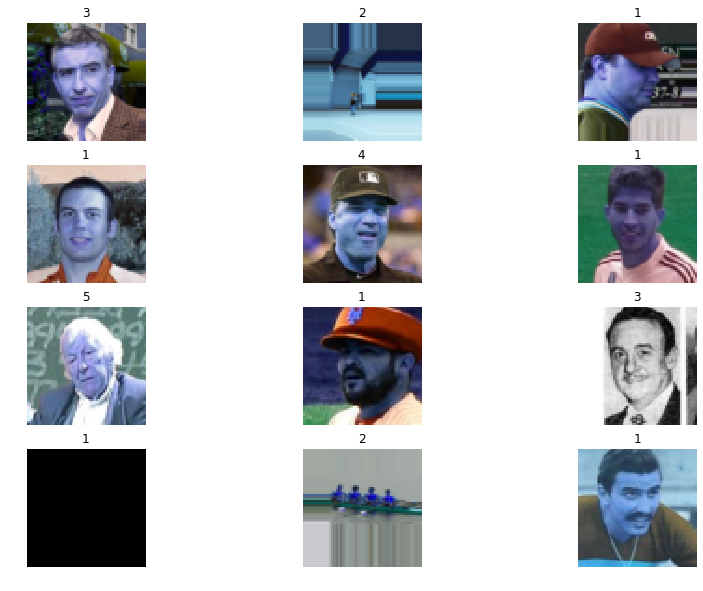

In [9]:
class_plot(12,data,inv_normalize = inv_normalize)

# Age-cgan models

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(3,32,5,2)
        self.conv2 = nn.Conv2d(32,64,5,2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,5,2)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,256,5,2)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.flatten = Flatten()
        self.linear1 = nn.Linear(256,4096)
        self.linear2 = nn.Linear(4096,100)
        
    def forward(self, input):
        x = self.leakyrelu(self.conv1(input))
        x = self.leakyrelu(self.batchnorm2(self.conv2(x)))
        x = self.leakyrelu(self.batchnorm3(self.conv3(x)))
        x = self.leakyrelu(self.batchnorm4(self.conv4(x)))
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [11]:
enc = encoder().to('cuda')
from torchsummary import summary
summary(enc,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]           2,432
         LeakyReLU-2           [-1, 32, 30, 30]               0
            Conv2d-3           [-1, 64, 13, 13]          51,264
       BatchNorm2d-4           [-1, 64, 13, 13]             128
         LeakyReLU-5           [-1, 64, 13, 13]               0
            Conv2d-6            [-1, 128, 5, 5]         204,928
       BatchNorm2d-7            [-1, 128, 5, 5]             256
         LeakyReLU-8            [-1, 128, 5, 5]               0
            Conv2d-9            [-1, 256, 1, 1]         819,456
      BatchNorm2d-10            [-1, 256, 1, 1]             512
        LeakyReLU-11            [-1, 256, 1, 1]               0
          Flatten-12                  [-1, 256]               0
           Linear-13                 [-1, 4096]       1,052,672
           Linear-14                  [

In [0]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(0.2)
        self.linear1 =  nn.Linear(106 , 2048)
        self.linear2 = nn.Linear(2048,256*8*8)
        self.batchnorm1d = nn.BatchNorm1d(256*8*8)
        self.upsample = nn.Upsample(scale_factor = (2,2))
        self.conv1 = nn.Conv2d(256,128,5,1,2)
        self.batchnorm1 = nn.BatchNorm2d(128,momentum=0.8)
        self.conv2 = nn.Conv2d(128,64,5,1,2)
        self.batchnorm2 = nn.BatchNorm2d(64,momentum=0.8)
        self.conv3 = nn.Conv2d(64,3,5,1,2)
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        size = len(input)
        input = torch.reshape(input,(size,106))
        x = self.dropout(self.leakyrelu(self.linear1(input)))
        x = self.dropout(self.leakyrelu(self.batchnorm1d(self.linear2(x))))
        x = torch.reshape(x,(size,256,8,8))
        x = self.leakyrelu(self.batchnorm1(self.conv1(self.upsample(x))))
        x = self.leakyrelu(self.batchnorm2(self.conv2(self.upsample(x))))
        x = self.tanh(self.conv3(self.upsample(x)))
        return x

In [13]:
gen = generator().to('cuda')
from torchsummary import summary
summary(gen,(106,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]         219,136
         LeakyReLU-2                 [-1, 2048]               0
           Dropout-3                 [-1, 2048]               0
            Linear-4                [-1, 16384]      33,570,816
       BatchNorm1d-5                [-1, 16384]          32,768
         LeakyReLU-6                [-1, 16384]               0
           Dropout-7                [-1, 16384]               0
          Upsample-8          [-1, 256, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         819,328
      BatchNorm2d-10          [-1, 128, 16, 16]             256
        LeakyReLU-11          [-1, 128, 16, 16]               0
         Upsample-12          [-1, 128, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]         204,864
      BatchNorm2d-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [0]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.linear1 =  nn.Linear(8192, 1)
        self.conv1 = nn.Conv2d(3,64,3,2,1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(70,128,3,2,1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256,3,2,1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,512,3,2,1)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.sigmoid = nn.Sigmoid()
        self.flatten = Flatten()
        
    def forward(self, image,label_input):
        x = self.leakyrelu(self.conv1(image))
        size = len(label_input)
        label_input = label_input.reshape((size,6,1,1))
        label_input = label_input.repeat([1,1,32,32])
        x = torch.cat((x,label_input),dim = 1)
        x = self.leakyrelu(self.batchnorm2(self.conv2(x)))
        x = self.leakyrelu(self.batchnorm3(self.conv3(x)))
        x = self.leakyrelu(self.batchnorm4(self.conv4(x)))
        x = self.flatten(x)
        x = self.sigmoid(self.linear1(x))
        return x

In [0]:
dis = discriminator().to('cuda')

In [0]:
class combined_network(nn.Module):
    def __init__(self,encoder,generator,recog):
        super(combined_network, self).__init__()
        self.encoder = encoder
        self.generator = generator
        self.recog = recog
    def forward(self, image , label_input):
        latent0 = self.encoder(image)
        x = torch.cat((latent0,label_input),dim = 1)
        gen_imgs = self.generator(x)
        embeddings = self.recog(gen_imgs)
        return embeddings

In [0]:
cn = combined_network(enc,gen,recog).to('cuda')

In [0]:
import torchvision.models as models
class face_recog(nn.Module):
  def __init__(self):
    super(face_recog, self).__init__()
    self.resnet = models.resnet18(pretrained = True)
    self.linear1 = nn.Linear(1000,128)
  def forward(self,image):
    x = self.resnet(image)
    x = self.linear1(x)
    norms = torch.norm(x, p=1, dim=1).data
    return x

In [26]:
recog = face_recog().to('cuda')
summary(recog,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [0]:
#optimizers
optimizer_G = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_E = torch.optim.Adam(enc.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_cn = torch.optim.Adam(cn.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [0]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0, 1)
    return image

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


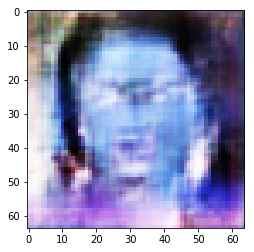

[Epoch 0/1000] [Batch 1947/1948] [D loss: 0.582564] [G loss: 0.670279]


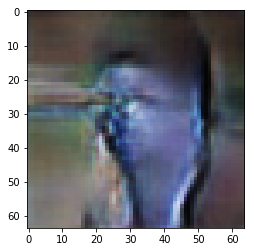

[Epoch 1/1000] [Batch 1947/1948] [D loss: 0.569025] [G loss: 0.726456]


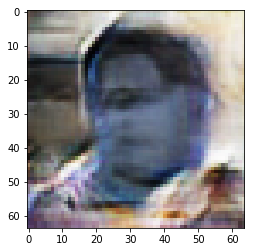

[Epoch 2/1000] [Batch 1947/1948] [D loss: 0.323145] [G loss: 0.964300]


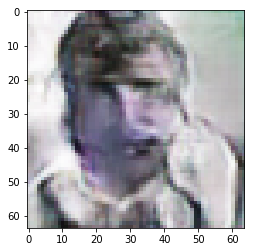

[Epoch 3/1000] [Batch 1947/1948] [D loss: 0.377690] [G loss: 0.996032]


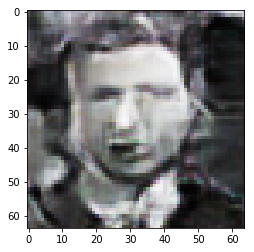

[Epoch 4/1000] [Batch 1947/1948] [D loss: 0.449692] [G loss: 1.340834]


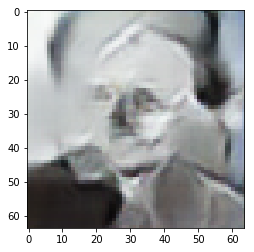

[Epoch 5/1000] [Batch 1947/1948] [D loss: 0.450956] [G loss: 1.072620]


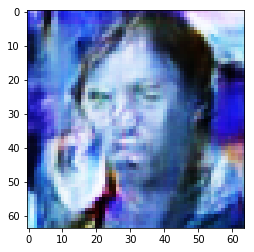

[Epoch 6/1000] [Batch 1947/1948] [D loss: 0.396959] [G loss: 0.996791]


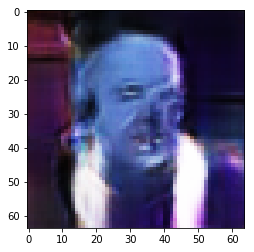

[Epoch 7/1000] [Batch 1947/1948] [D loss: 0.232697] [G loss: 2.037673]


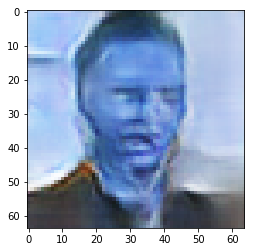

[Epoch 8/1000] [Batch 1947/1948] [D loss: 0.245150] [G loss: 1.655218]


In [0]:
g_losses = []
d_losses = []

#define loss and optimizers
adversarial_loss = torch.nn.BCELoss()
mse = nn.MSELoss()
#train
Tensor = torch.cuda.FloatTensor if 'cuda' else torch.FloatTensor
for epoch in range(10):1
    for i, (imgs,age) in enumerate(dataloader):

        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(Tensor))
        optimizer_G.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],100,1,1))))
        age = age.type(torch.cuda.FloatTensor)
        age = torch.reshape(age,(-1,6,1,1))
        z = torch.cat((z,age),dim = 1)
        gen_imgs = gen(z)
        b = dis(gen_imgs,age)
        g_loss = adversarial_loss(b, valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        real_loss = adversarial_loss(dis(real_imgs,age), valid)
        fake_loss = adversarial_loss(dis(gen_imgs.detach(),age), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    if(epoch%1==0):
      a = gen_imgs[0]
      a = im_convert(a)
      plt.imshow(a)
      plt.show()
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, 1000, i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))